In [4]:
%load_ext autoreload
%autoreload 2
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from m3util.viz.style import set_style
from m3util.viz.layout import layout_fig
from dl_utils.utils.utils import list_to_dict, sort_tasks_by_size, viz_h5_structure, find_symm_index_in_hdf5
from dl_utils.utils.viz import verify_image_vector
from dl_utils.utils.dataset import viz_dataloader, split_train_valid, hdf5_dataset
from dl_utils.training.build_model import resnet50_, fpn_resnet50_classification, xcit_small
from dl_utils.analysis.case_analysis import prediction_vs_actual, most_confused_pairs, show_prediction_example
from dl_utils.analysis.confusion_matrix import plot_cm, show_multiple_cm
from dl_utils.analysis.attention_map import AttentionMapVisualizer
from dl_utils.analysis.evaluate_symmetry import crop_image_with_mask, find_valid_starting_points, calculate_shift_tolerant_ssim, find_all_regions
from dl_utils.packed_functions import viz_4confusion_matrix, plot_attention_map
set_style("printing")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn


### load dataset

In [5]:
ds_path = f'../../../Wallpaper_Group_Symmetry_Dataset/datasets/imagenet_v5/imagenet_v5_rot_10k_fix_vector_a100_0.h5'
with h5py.File(ds_path) as h5:
    viz_h5_structure(h5)

'Group': imagenet
  'Dataset': data; Shape: (10013, 256, 256, 3); dtype: uint8
  'Dataset': labels; Shape: (10013,); dtype: uint8
  'Dataset': primitive_uc_vector_a; Shape: (10013, 2); dtype: int32
  'Dataset': primitive_uc_vector_b; Shape: (10013, 2); dtype: int32
  'Dataset': rotation_angle; Shape: (10013,); dtype: uint8
  'Dataset': shape; Shape: (10013,); dtype: uint8
  'Dataset': translation_start_point; Shape: (10013, 2); dtype: int32
  'Dataset': translation_uc_vector_a; Shape: (10013, 2); dtype: int32
  'Dataset': translation_uc_vector_b; Shape: (10013, 2); dtype: int32


image shape is (256, 256, 3), class: p4, translation start point: [107  81], va: [20 23], vb: [ 23 -20], VA: [41 46], VB: [ 46 -41]


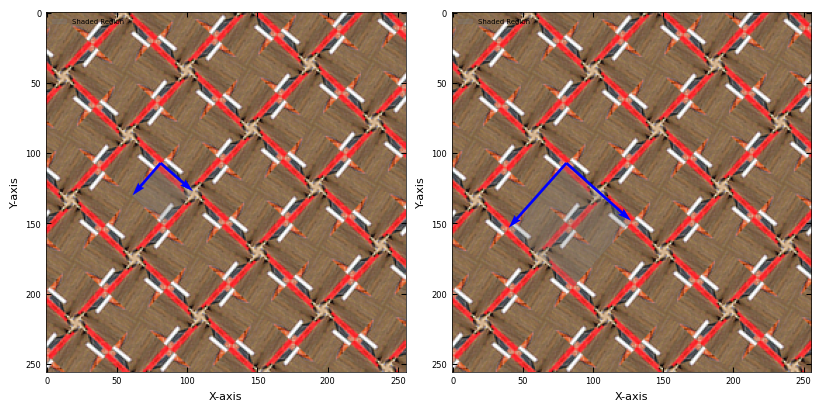

In [19]:
ds_path = f'../../../Wallpaper_Group_Symmetry_Dataset/datasets/imagenet_v5/imagenet_v5_rot_10k_fix_vector_a100_0.h5'
group = 'imagenet'
with h5py.File(ds_path) as h5:
    index = find_symm_index_in_hdf5(h5, symm_str='p4', group=group, index_start=1000, index_end=None)
    
    img, label, ts = h5[group]['data'][index], h5[group]['labels'][index], h5[group]['translation_start_point'][index]
    va, vb = h5[group]['primitive_uc_vector_a'][index], h5[group]['primitive_uc_vector_b'][index]
    VA, VB = h5[group]['translation_uc_vector_a'][index], h5[group]['translation_uc_vector_b'][index]
    
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

print(f"image shape is {img.shape}, class: {label_converter[label]}, translation start point: {ts}, va: {va}, vb: {vb}, VA: {VA}, VB: {VB}")

fig, axes = layout_fig(2, 2, figsize=(10, 4))
verify_image_vector(ax=axes[0], image=img, ts=ts, va=va, vb=vb)
verify_image_vector(ax=axes[1], image=img, ts=ts, va=VA, vb=VB)
plt.show()

### crop the pattern

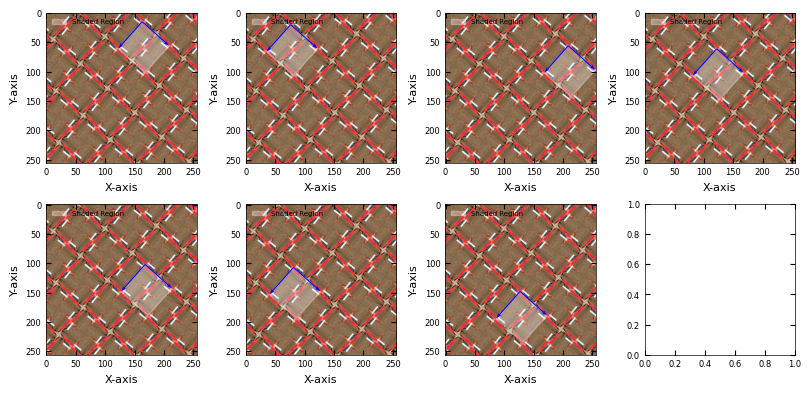

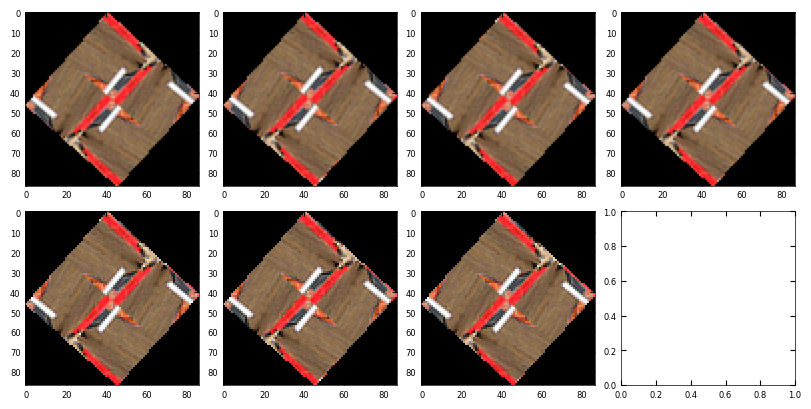

In [20]:
regions, masks, valid_ts_list = find_all_regions(img, ts, VA, VB)

fig, axes = layout_fig(len(valid_ts_list), 4, figsize=(8, 2*(len(valid_ts_list)//5+1)))
for ax, ts in zip(axes, valid_ts_list):
    verify_image_vector(ax=ax, image=img, ts=ts, va=VA, vb=VB, shade_alpha=0.3, shade_color='white')
plt.show()
   
fig, axes = layout_fig(len(valid_ts_list), 4, figsize=(8, 2*(len(valid_ts_list)//5+1)))
for ax, ts, cropped_img in zip(axes, valid_ts_list, regions):
    ax.imshow(cropped_img)
plt.show()

### calculate shift tolerant ssim

Overall SSIM Similarity: 0.5829


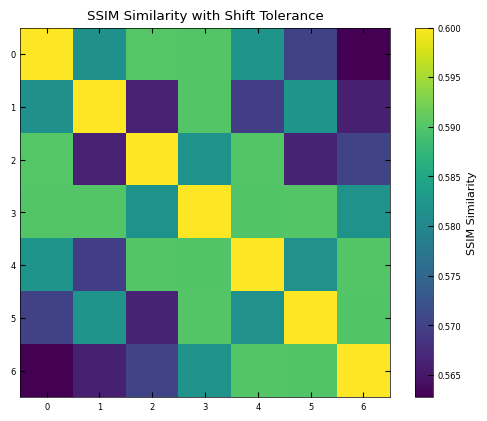

In [21]:
# Example usage
similarity_matrix = calculate_shift_tolerant_ssim(regions, max_shift=2)
print(f'Overall SSIM Similarity: {similarity_matrix.mean():.4f}')

import matplotlib.pyplot as plt
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='SSIM Similarity')
plt.title('SSIM Similarity with Shift Tolerance')
plt.show()

### attention map

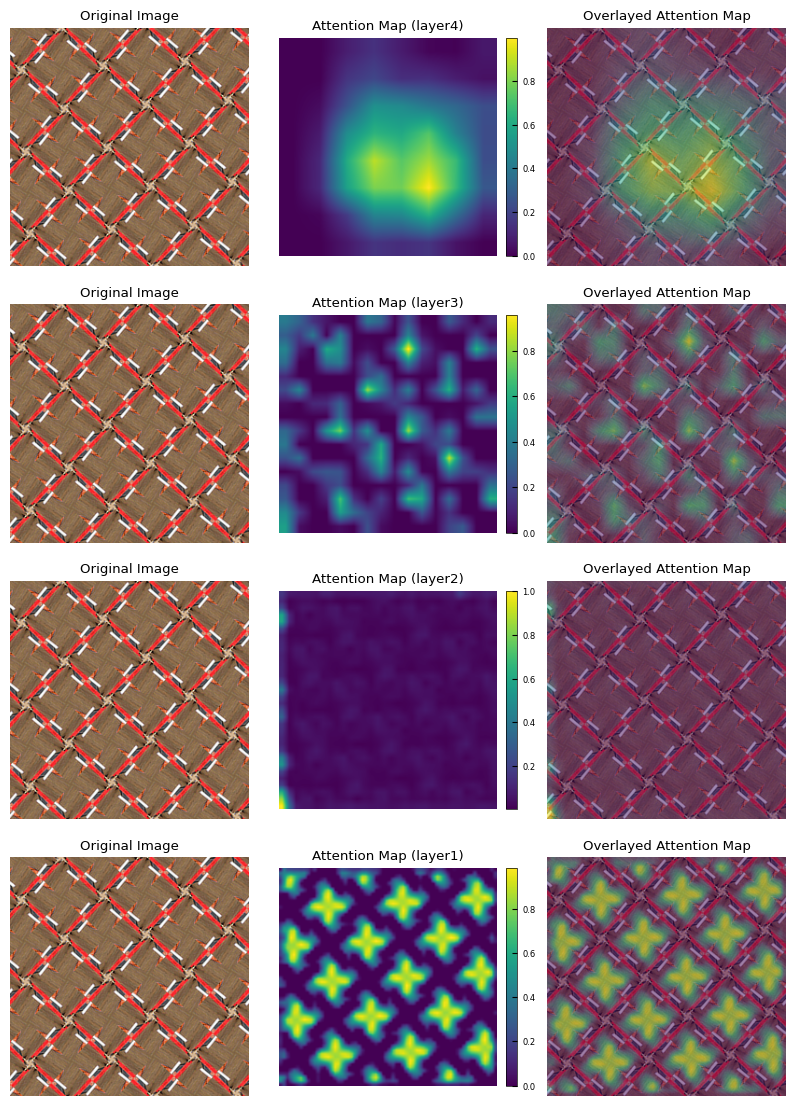

In [ ]:
device = torch.device('cuda:0')
model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()
layers = ['layer4', 'layer3', 'layer2', 'layer1']
model_type = 'ResNet50'

visualizer = AttentionMapVisualizer(device=device)
input_tensor = transforms.ToTensor()(img).unsqueeze(0)  # Example input tensor (N, C, H, W)
# stats = f"True: {label} | Predicted: " + f", ".join(f"{pred}({prob.item() * 100:.2f}%)" for prob, pred in zip(probs, top_predictions))

layers = ['layer4', 'layer3', 'layer2', 'layer 1']
attention_map_resized_list, overlay_attention_map_list = [], []
fig, axes = layout_fig(len(layers)*3, 3, figsize=(8, len(layers)*2.8), subplot_style='subplots', layout='tight')
for i, layer in enumerate(layers):
    if model_type == 'ResNet50':
        input_image_np, attention_map_resized = visualizer.generate_cnn_attention_map(model, input_tensor, layer_name=layer)
    elif model_type == 'XCiT':
        input_image_np, attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=layer)
        
    overlay_attention_map = visualizer.visualize_attention_map(input_image_np, attention_map_resized, keyword=layer, fig=fig, axes=axes[i*3:i*3+3])
    attention_map_resized_list.append(attention_map_resized)
    overlay_attention_map_list.append(overlay_attention_map)
    
# plt.suptitle(f"{task_name}: {stats}", fontsize=10)
plt.show()

In [ ]:
layout_fig(2, 2, figsize=(10, 4), subplot_style='gridspec', )

/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.12/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


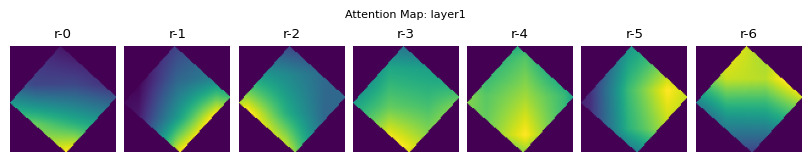

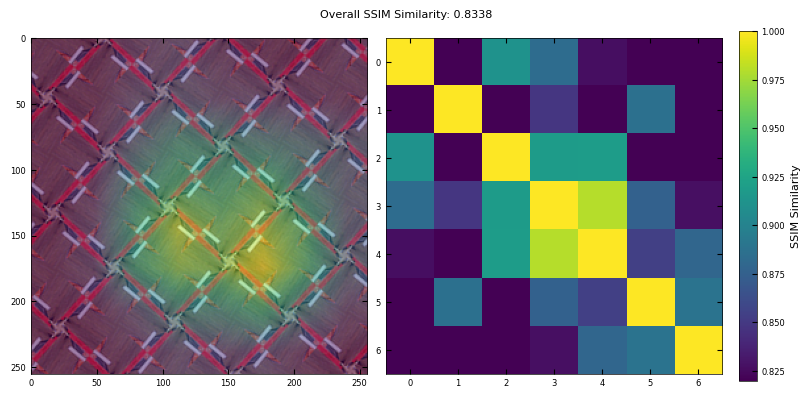

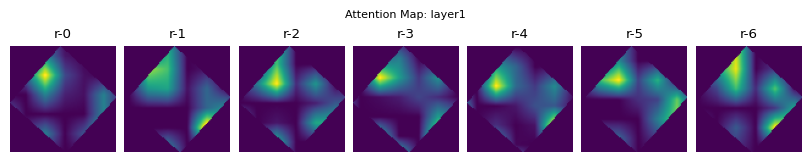

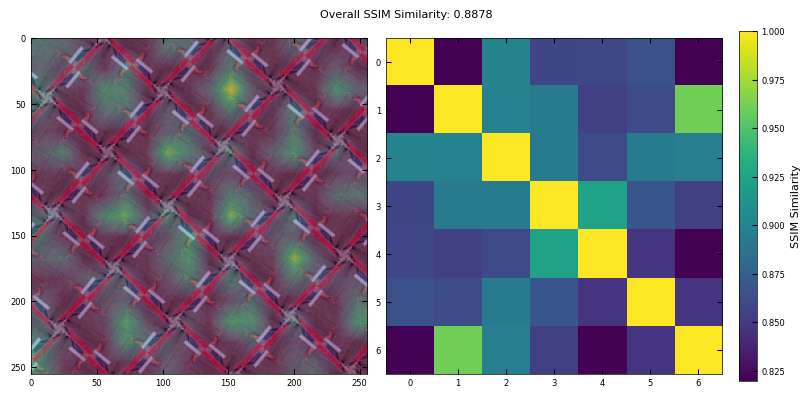

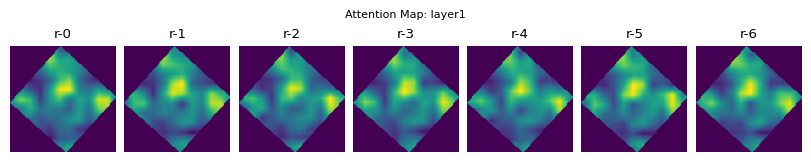

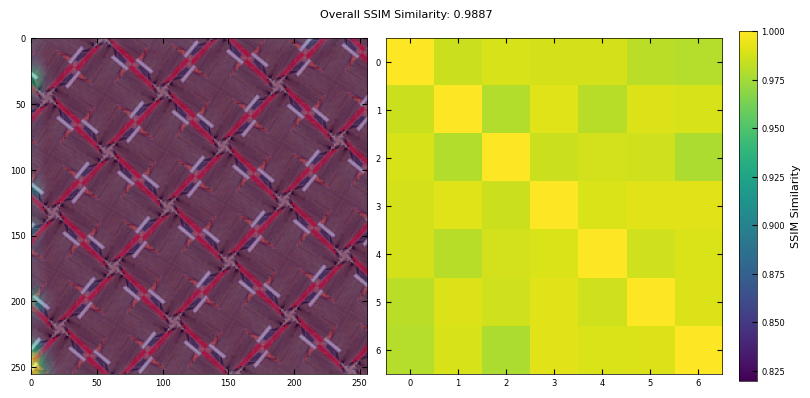

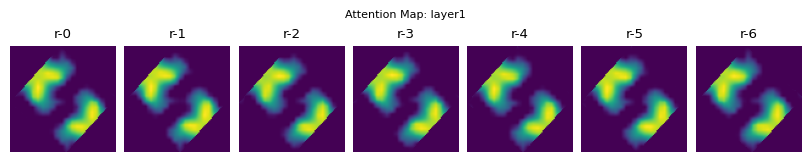

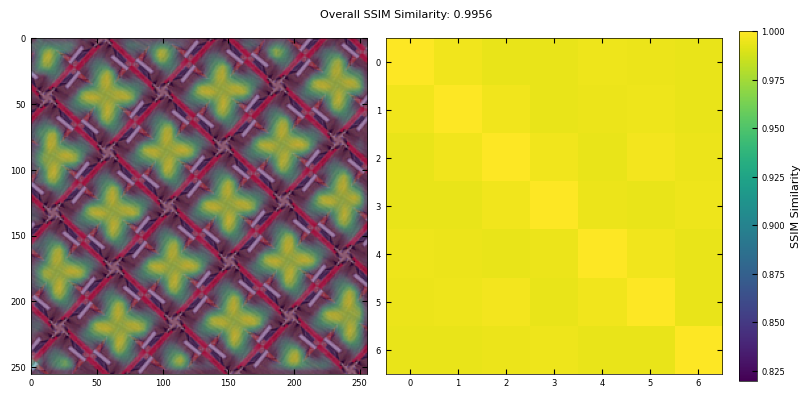

In [ ]:
for attention_map, overlay_attention_map in zip(attention_map_resized_list, overlay_attention_map_list):

    regions, masks, valid_ts_list = find_all_regions(attention_map, ts, VA, VB)
    # fig, axes = layout_fig(len(valid_ts_list), 4, figsize=(8, 2*(len(valid_ts_list)//5+1)))
    # for ax, ts in zip(axes, valid_ts_list):
    #     verify_image_vector(ax=ax, image=attention_map, ts=ts, va=VA, vb=VB, shade_alpha=0.3, shade_color='white')
    # plt.show()

    # similarity_matrix = calculate_shift_tolerant_ssim(regions, max_shift=2)
    similarity_matrix = calculate_shift_tolerant_ssim(regions, max_shift=2, highpass_filter=True)
    # similarity_matrix = calculate_shift_tolerant_ssim(regions, max_shift=2, edge_filter=True)
    # similarity_matrix = calculate_shift_tolerant_ssim(regions, max_shift=2, use_ncc=True, weight_ssim=0.5, weight_ncc=0.5)
    # similarity_matrix = calculate_shift_tolerant_ssim(regions, max_shift=2, edge_filter=True, use_ncc=True, weight_ssim=0.6, weight_ncc=0.4)

    fig, axes = layout_fig(len(valid_ts_list), 7, figsize=(8, 1*(len(valid_ts_list)//5+1)))
    for i, (ax, ts, region) in enumerate(zip(axes, valid_ts_list, regions)):
        ax.imshow(region)
        ax.axis('off')
        ax.set_title(f"r-{i}")
        
    fig, axes = layout_fig(2, 2, figsize=(8, 4))
    axes[0].imshow(overlay_attention_map)
    
    im1 = axes[1].imshow(similarity_matrix, cmap='viridis', interpolation='nearest', vmin=0.82, vmax=1)
    plt.colorbar(im1, ax=axes[1], label='SSIM Similarity')
    plt.suptitle(f"Attention Map: {layer} | Overall SSIM Similarity: {similarity_matrix.mean():.4f}")
    plt.show()

### design symmetry operation evaluation

In [ ]:
for attention_map, overlay_attention_map in zip(attention_map_resized_list, overlay_attention_map_list):

    regions, masks, valid_ts_list = find_all_regions(attention_map, ts, VA, VB)
    similarity_matrix = calculate_shift_tolerant_ssim(regions, max_shift=2, highpass_filter=True)

    fig, axes = layout_fig(2, 2, figsize=(8, 3))
    axes[0].imshow(overlay_attention_map)
    
    im1 = axes[1].imshow(similarity_matrix, cmap='viridis', interpolation='nearest', vmin=0.82, vmax=1)
    plt.colorbar(im1, ax=axes[1], label='SSIM Similarity')
    
    plt.suptitle(f"Attention Map: {layer} | Overall SSIM Similarity: {similarity_matrix.mean():.4f}")
    plt.show()

In [49]:
print(len(regions), len(attention_map_resized_list), len(overlay_attention_map_list))
print(regions[0].shape, attention_map_resized_list[0].shape, overlay_attention_map_list[0].shape)

7 4 4
(87, 87) (256, 256) (256, 256, 3)


### draft

Valid Starting Points (ts): [(15, 163), (20, 76), (56, 209), (61, 122), (102, 168), (107, 81), (148, 127)]
Total valid starting points found: 7


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.12/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


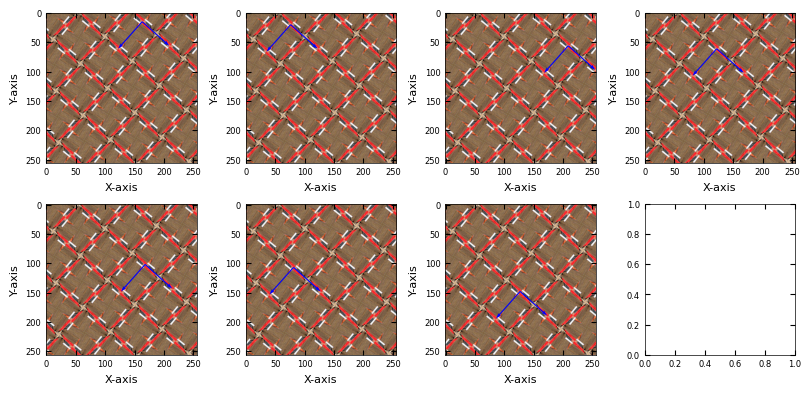

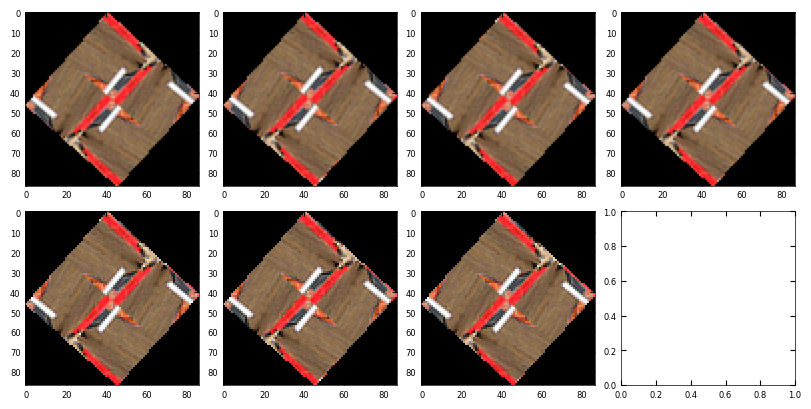

In [ ]:
cropped_img, mask = crop_image_with_mask(img, ts, VA, VB)

# fig, axes = layout_fig(2, 2, figsize=(10, 5))
# axes[0].imshow(cropped_img)
# axes[1].imshow(mask, cmap='gray')
# plt.show()

valid_ts_list = find_valid_starting_points(img.shape[:2], ts, VA, VB)

# Print first few valid starting points
print("Valid Starting Points (ts):", valid_ts_list[:10])
print(f"Total valid starting points found: {len(valid_ts_list)}")


valid_ts_list = find_valid_starting_points(img, ts, VA, VB)
cropped_img_list, mask_list = [], []
for ts in valid_ts_list:
    cropped_img, mask = crop_image_with_mask(img, ts, VA, VB)
    cropped_img_list.append(cropped_img)
    mask_list.append(mask)
 
fig, axes = layout_fig(len(valid_ts_list), 4, figsize=(8, 2*(len(valid_ts_list)//5+1)))
for ax, ts in zip(axes, valid_ts_list):
    verify_image_vector(ax=ax, image=img, ts=ts, va=VA, vb=VB)
plt.show()
   
fig, axes = layout_fig(len(valid_ts_list), 4, figsize=(8, 2*(len(valid_ts_list)//5+1)))
for ax, ts, cropped_img in zip(axes, valid_ts_list, cropped_img_list):
    ax.imshow(cropped_img)
plt.show()

### calculate similarity

In [41]:
valid_ts_list

[]

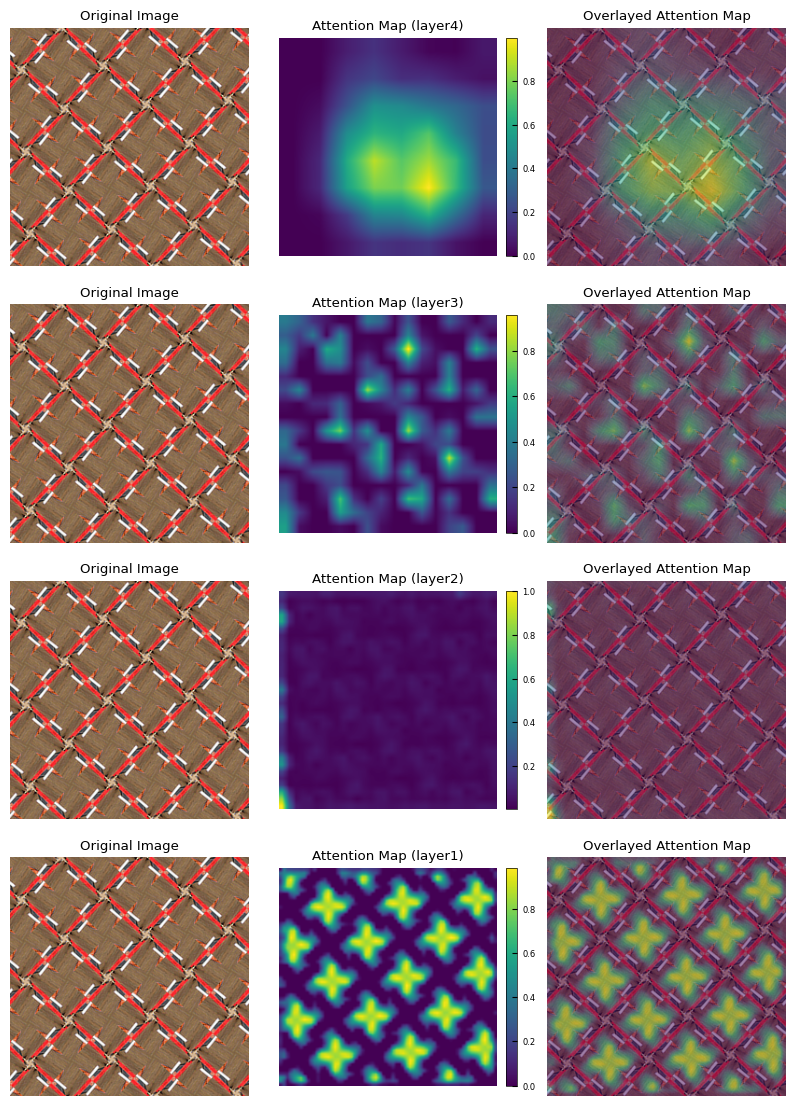

In [105]:
device = torch.device('cuda:0')
model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()
layers = ['layer4', 'layer3', 'layer2', 'layer1']
model_type = 'ResNet50'

visualizer = AttentionMapVisualizer(device=device)
input_tensor = transforms.ToTensor()(img).unsqueeze(0)  # Example input tensor (N, C, H, W)
# stats = f"True: {label} | Predicted: " + f", ".join(f"{pred}({prob.item() * 100:.2f}%)" for prob, pred in zip(probs, top_predictions))

layers = ['layer4', 'layer3', 'layer2', 'layer1']
fig, axes = layout_fig(len(layers)*3, 3, figsize=(8, len(layers)*2.8), subplot_style='subplots', layout='tight')
for i, layer in enumerate(layers):
    if model_type == 'ResNet50':
        input_image_np, attention_map_resized = visualizer.generate_cnn_attention_map(model, input_tensor, layer_name=layer)
    elif model_type == 'XCiT':
        input_image_np, attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=layer)
        
    visualizer.visualize_attention_map(input_image_np, attention_map_resized, keyword=layer, fig=fig, axes=axes[i*3:i*3+3])

# plt.suptitle(f"{task_name}: {stats}", fontsize=10)
plt.show()

In [ ]:

symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)
bs = 256
num_workers = 1

# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor(), classes=symmetry_classes)
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

# atom
atom_ds = hdf5_dataset('../../datasets/atom_v5_rot_200k.h5', folder='atom', transform=transforms.ToTensor(), classes=symmetry_classes)
atom_dl = DataLoader(atom_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

# noise
noise_ds = hdf5_dataset('../../datasets/noise_v5_rot_100k.h5', folder='noise', transform=transforms.ToTensor(), classes=symmetry_classes)
noise_dl = DataLoader(noise_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')

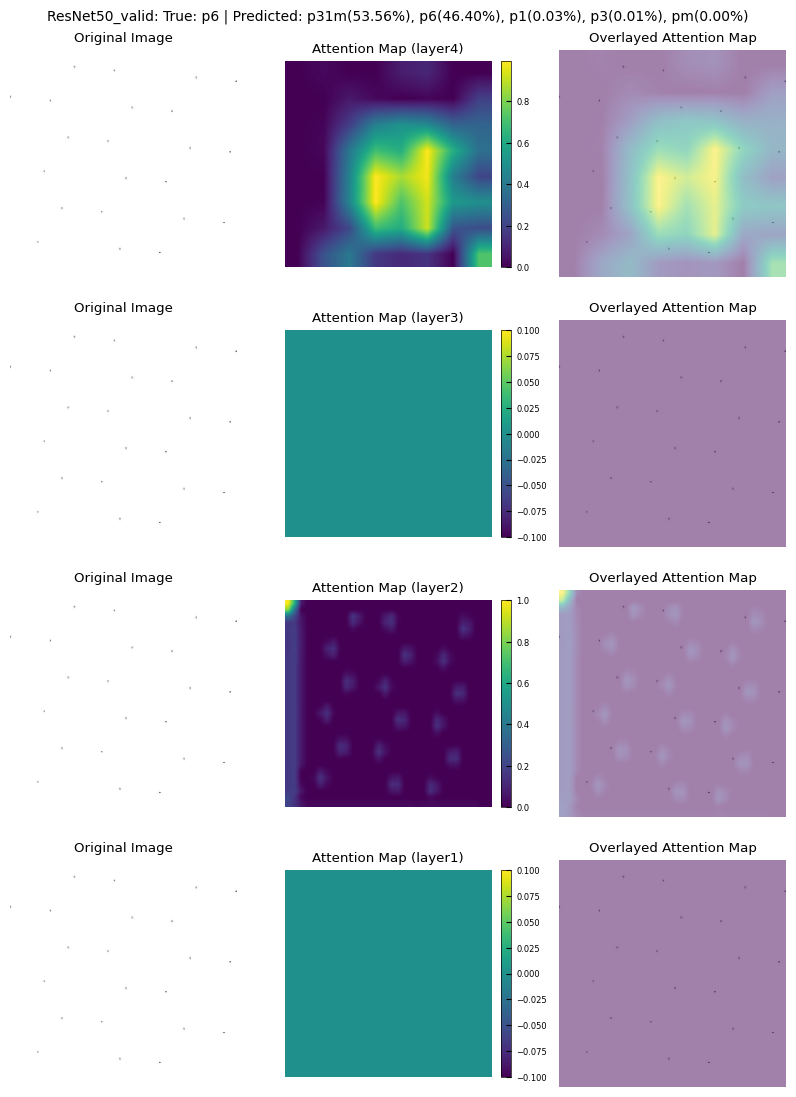

In [2]:
device = torch.device('cuda:9')
model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()
layers = ['layer4', 'layer3', 'layer2', 'layer1']

input_image_np, attention_map_resized = plot_attention_map(model, valid_dl, copnfusion_pair=['p6', 'p31m'], layers=layers, model_type='ResNet50', task_name='ResNet50_valid', device=device)


In [3]:
input_image_np.shape, attention_map_resized.shape

((256, 256, 3), (256, 256))

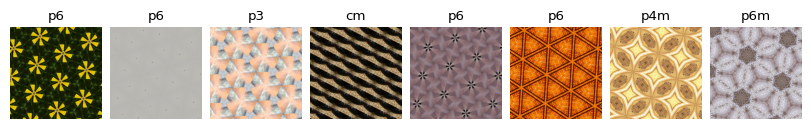

In [10]:
# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor(), classes=symmetry_classes)
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

In [11]:
metrics = valid_ds.list_metrics()
print("Available metrics:", metrics)

Available metrics: ['primitive_uc_vector_a', 'primitive_uc_vector_b', 'shape', 'translation_start_point', 'translation_uc_vector_a', 'translation_uc_vector_b']


In [40]:
from dl_utils.utils.dataset import verify_image_in_hdf5_file_symmetry_operation, verify_image_in_hdf5_file

Total number of images in the dataset:  204000
Randomly selected images:  [ 76467 130037 137540]


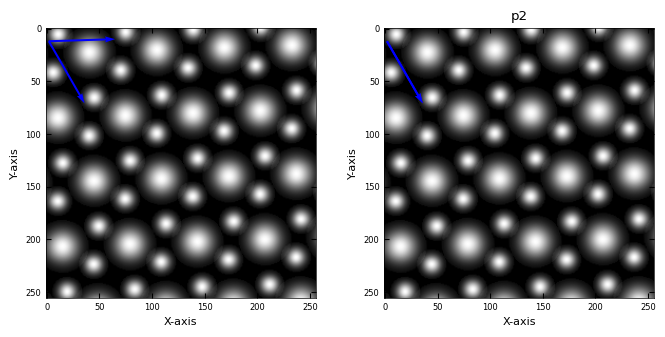

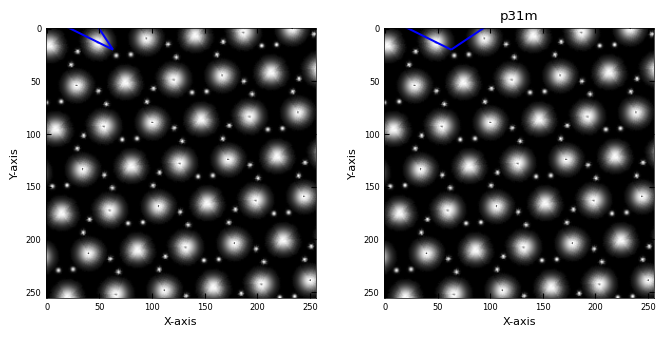

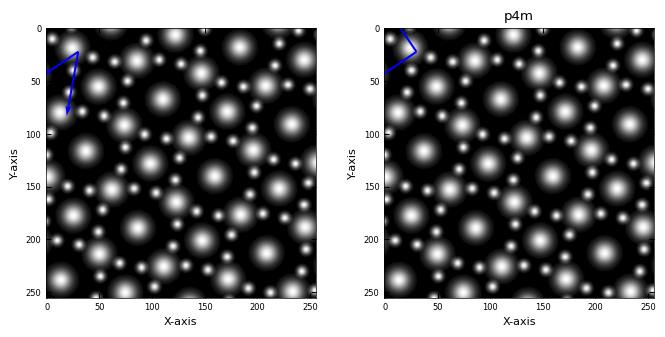

In [56]:
imgs, labels_str, metadata = verify_image_in_hdf5_file('../../datasets/atom_v5_rot_200k.h5', n_list=3, group='atom', viz=True)

Total number of images in the dataset:  10710034
Randomly selected images:  [  180141  7552479 10148200]


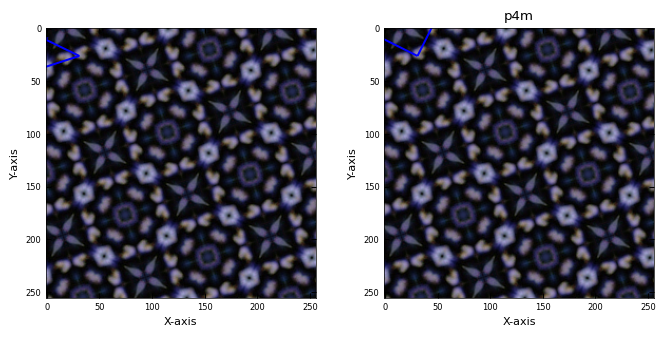

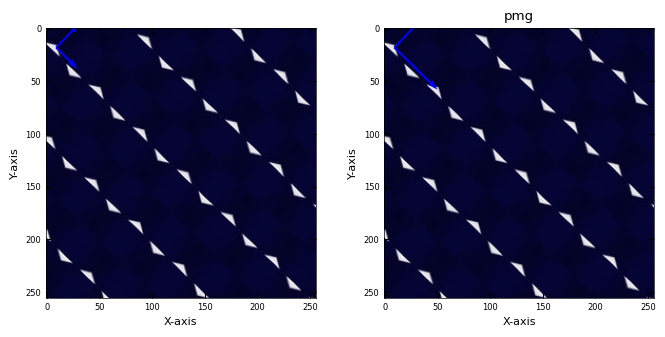

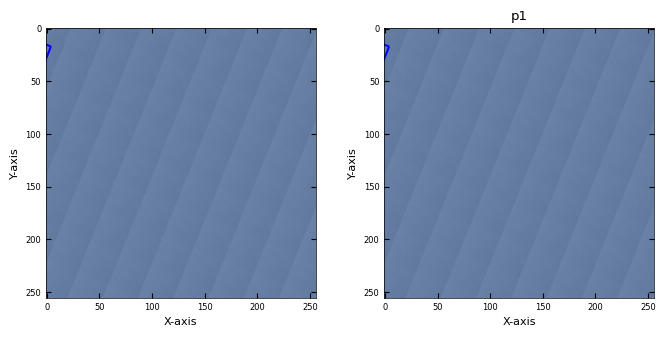

In [54]:
imgs, labels_str, metadata = verify_image_in_hdf5_file('../../datasets/imagenet_v5_rot_10m.h5', n_list=3, group='train', viz=True)